# Unsupervised Discovery of Mobile User Personas for UX Strategy

## Problem description

I'm a UX Director at Google and I've been working on UX Strategy problems for near 20 years. I've been curious to what extent can unsuprvised machine learning aid strategists in finding user segments and implicit personas.

The primary goal of this project will be to perform unsupervised learning to identify and profile distinct user segments within a mobile application user base. Instead of relying on predefined, explicit, sets of personas and segments, I'm going to define clustering models that will find and define models as they emerge from the data.

## Data set description
This project will use the Mobile Device Usage and User Behavior Dataset hosted on Kaggle. This dataset provides 700 records of individual user interaction patterns, including key features relevant to mobile behavior:

* App Usage Time (min/day): Total daily minutes spent actively using applications.
* Screen On Time (hours/day): Total daily time the screen is active.
* Battery Drain (mAh/day): Daily battery consumption.
* Data Usage (MB/day): Daily mobile data consumption.
* Age and Gender: Demographic features used to profile the final clusters.

The dataset contains also a pre-assigned 'User Behavior Class' column, but I will ignore it for the unsupervised analysis.

## My approach
The project follows a standard machine learning workflow:
* **Exploratory data analysis (EDA)**. I'll inspect, analyse and clean the available data. Based on my preliminary inspection I think I'll have to standardize the numerical features (e.g., scale 'Battery Drain' and 'Screen On Time') to eliminate bias introduced by differing scales.
* **Data preprocessing**. To address the "curse of dimensionality" (and improve model performance), I'll perform Principal Component Analysis (PCA)
* **Model building and training**. I'll define, train, compare two unsupervised approaches - K-Means Clustering and Hierarchical Clustering.

I'll finish the report with an analysis of results, recommendations of next steps and a few words on the practical applicability of this work.

## Data preparation
First, I'm going to download the data. I'm using Colab, so I'm setting up the system in a way that uses the Colab secrets to store API key and Kaggle username. If you wish to run this notebook in Colab – fill in you secrets (menu on the left, icon of a key).

I noticed that in the dataset there are categorical and numerical features. I'm keeping splitted and combined set to have flexibility during the analysis and training.

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from google.colab import userdata

# Set up kaggle API and download data
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY_M')

!kaggle datasets download -d valakhorasani/mobile-device-usage-and-user-behavior-dataset
!unzip -o mobile-device-usage-and-user-behavior-dataset.zip

# Loading data to pandas df
df = pd.read_csv('user_behavior_dataset.csv')

# Define feature set with a split to numerical and categorical
numerical_features = ['App Usage Time (min/day)', 'Screen On Time (hours/day)',
                      'Battery Drain (mAh/day)', 'Data Usage (MB/day)']
categorical_features = ['Operating System']

# Combine both to have a common set
features_to_use = numerical_features + categorical_features
X = df[features_to_use].copy()

print("Data Loaded Successfully.")
print("Feature Matrix Shape:", X.shape)
print(f"Numerical Features: {len(numerical_features)}")
print(f"Categorical Features: {len(categorical_features)}")
display(X.head())

Dataset URL: https://www.kaggle.com/datasets/valakhorasani/mobile-device-usage-and-user-behavior-dataset
License(s): apache-2.0
mobile-device-usage-and-user-behavior-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  mobile-device-usage-and-user-behavior-dataset.zip
  inflating: user_behavior_dataset.csv  
Data Loaded Successfully.
Feature Matrix Shape: (700, 5)
Numerical Features: 4
Categorical Features: 1


,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Data Usage (MB/day),Operating System
0,393,6.4,1872,1122,Android
1,268,4.7,1331,944,Android
2,154,4.0,761,322,Android
3,239,4.8,1676,871,Android
4,187,4.3,1367,988,iOS


## Exploratory Data Analysis
To ensure the dataset was going to work for unsupervised clustering, I performed a robust Exploratory Data Analysis (EDA). I primarily focused on data integrity, distribution shapes, and feature relationships.

1. **Data distribution**. I utilized .describe() to check for missing values and inspecting the  range of features. I also plotted histograms to take a look at the numerical variables (App Usage, Screen Time, Battery Drain, and Data Usage) and check if they are in any way skewed. Finally, I used boxplots identify potential outliers that could distort distance-based clustering.

2. **Multivariate Analysis**. I generated a correlation heatmap to detect multicollinearity among the behavioral metrics. High correlations suggest that certain features may be redundant.

3. **Categorical Analysis**. I analyzed the class balance between Android and iOS users and used violin plots and pair plots to visually inspect if user behavior varied significantly between the two platforms.

--- 1. DATA INTEGRITY CHECK ---
Missing Values:
App Usage Time (min/day)      0
Screen On Time (hours/day)    0
Battery Drain (mAh/day)       0
Data Usage (MB/day)           0
Operating System              0
dtype: int64
------------------------------
--- 2. STATISTICAL SUMMARY ---


,count,mean,std,min,25%,50%,75%,max
App Usage Time (min/day),700.0,271.128571,177.199484,30.0,113.25,227.5,434.25,598.0
Screen On Time (hours/day),700.0,5.272714,3.068584,1.0,2.50,4.9,7.40,12.0
Battery Drain (mAh/day),700.0,1525.158571,819.136414,302.0,722.25,1502.5,2229.50,2993.0
Data Usage (MB/day),700.0,929.742857,640.451729,102.0,373.00,823.5,1341.00,2497.0


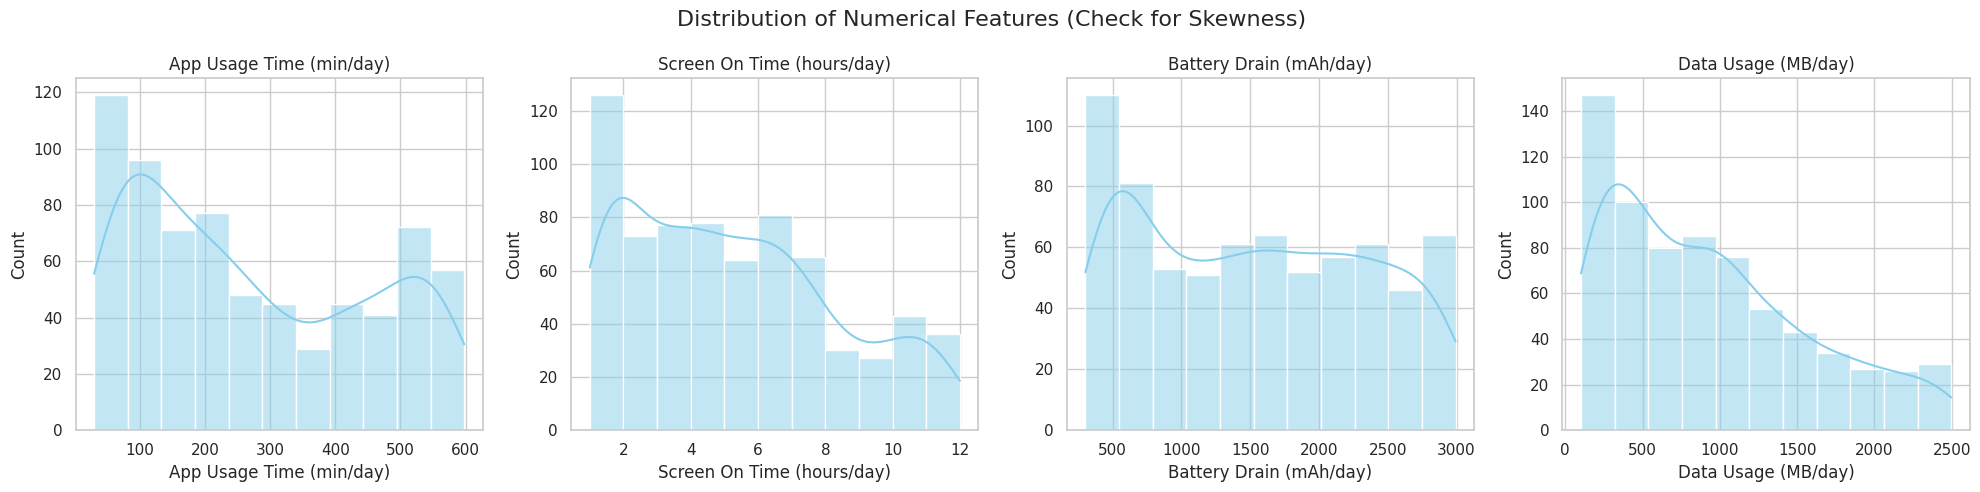

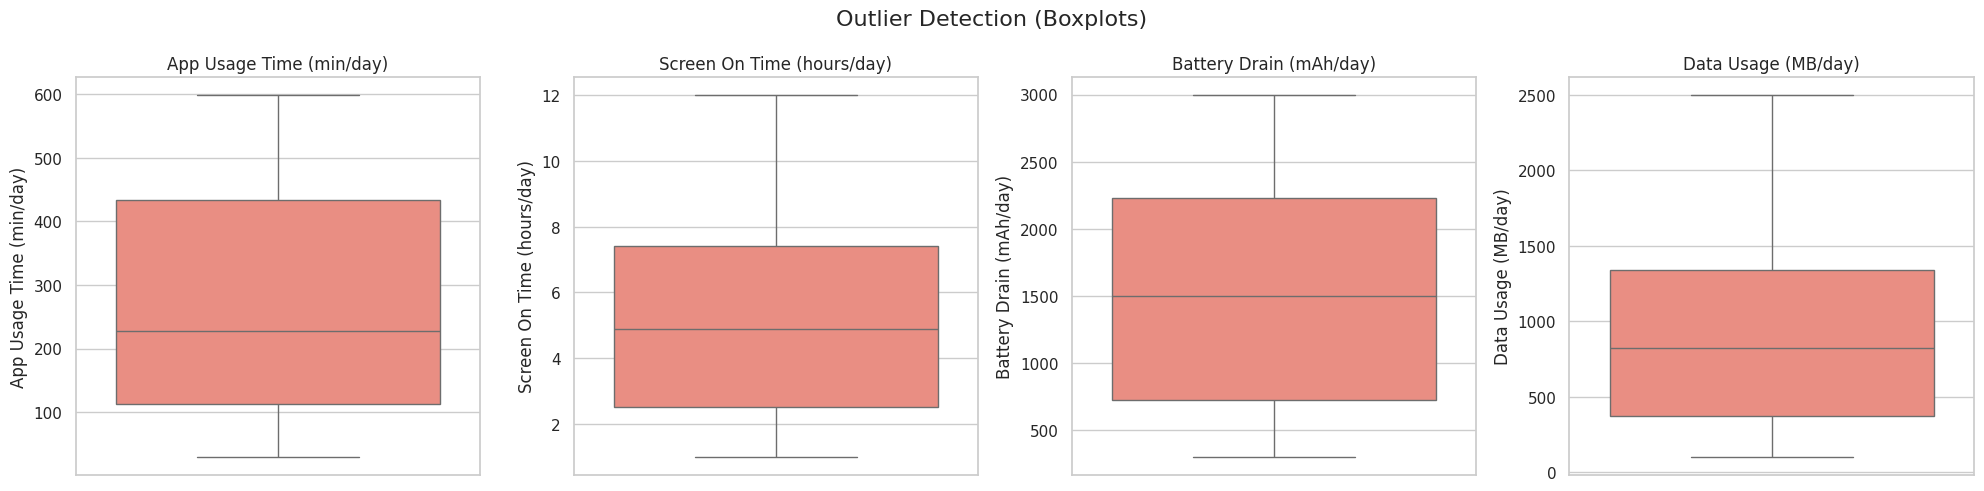

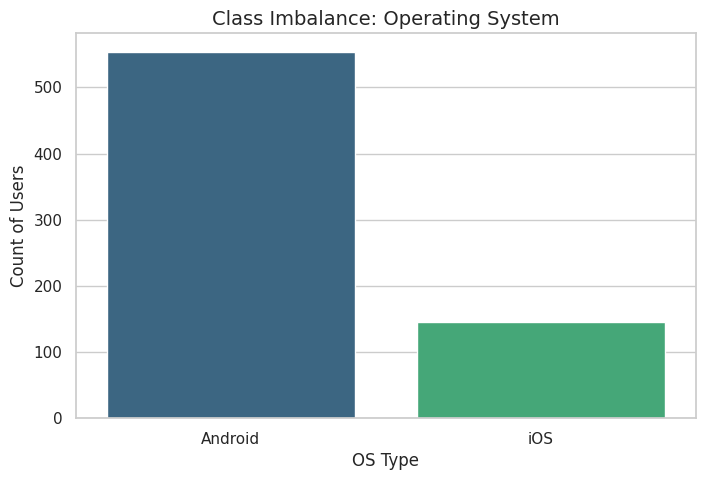

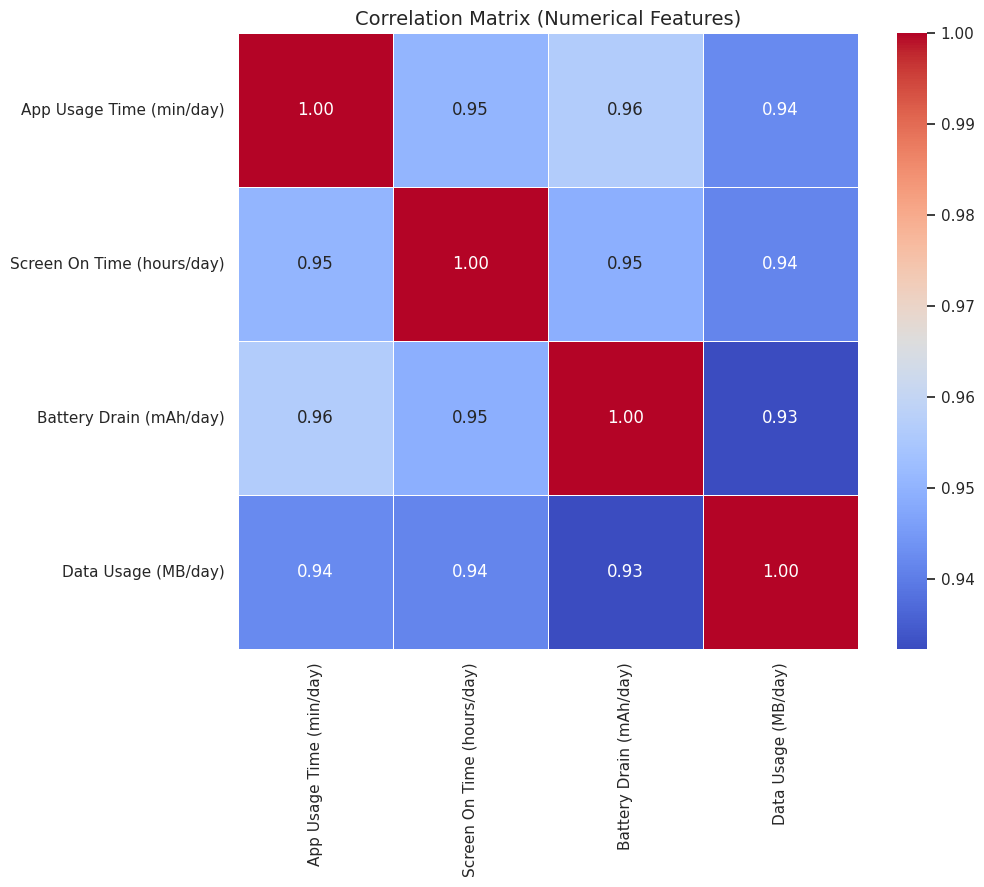

--- 3. MULTIVARIATE RELATIONSHIPS (Pairplot) ---


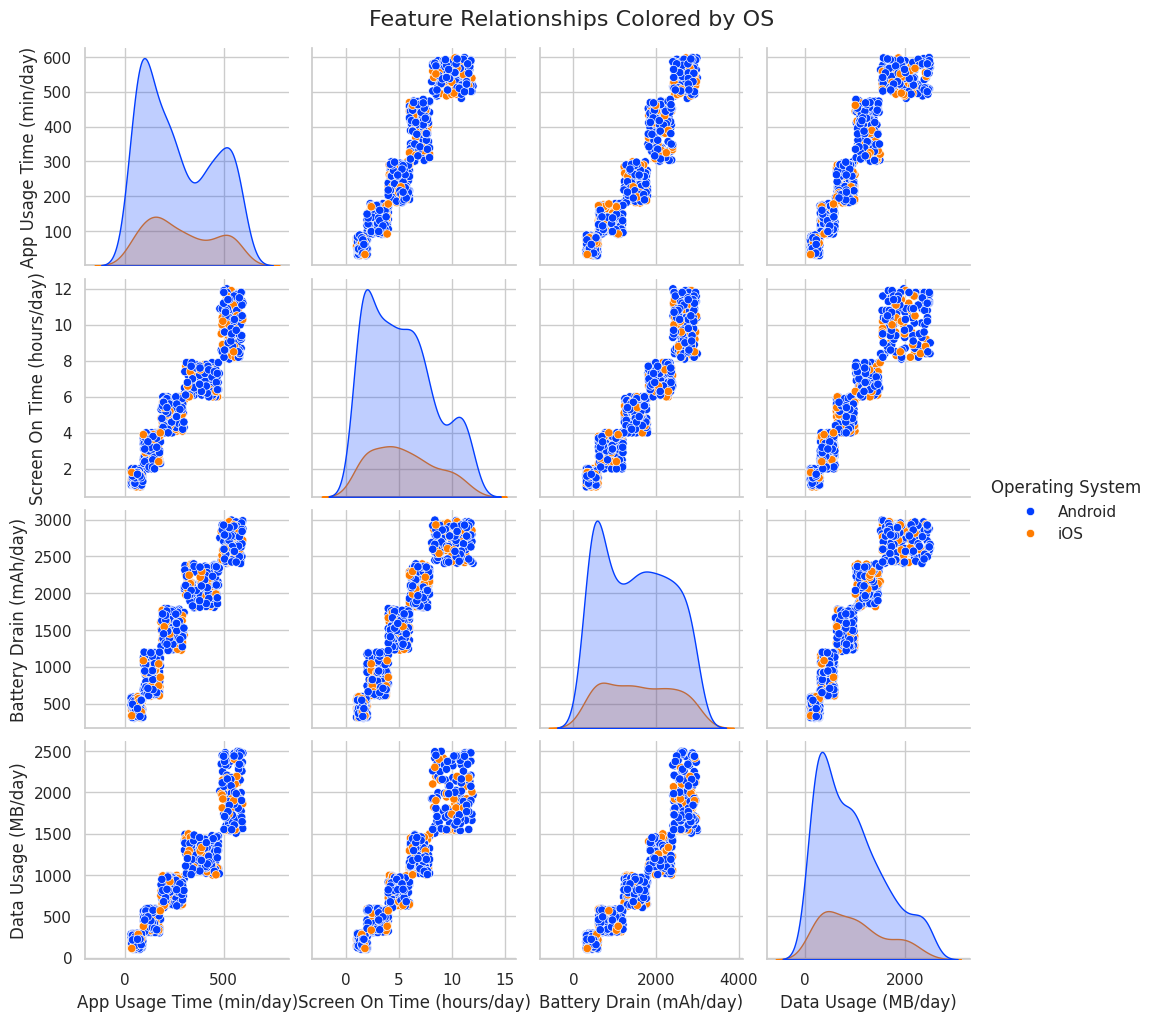

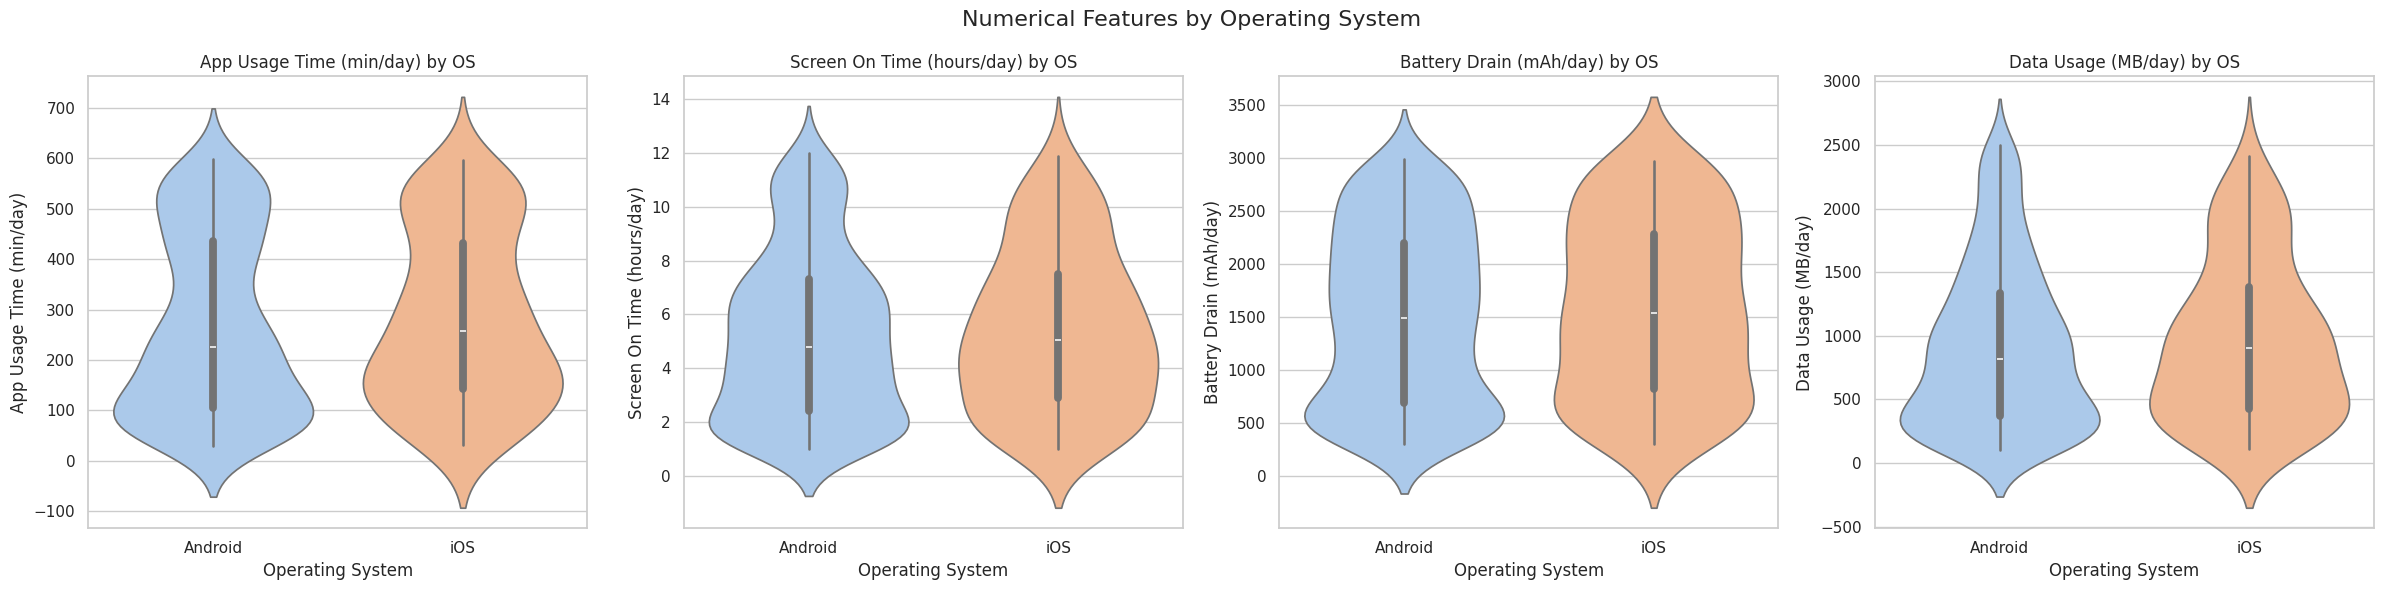

In [6]:
# --- RICHER EXPLORATORY DATA ANALYSIS (EDA) ---
# Ensure libraries are imported (just in case)
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid", palette="muted")

# Define feature groups for iteration
numerical_cols = ['App Usage Time (min/day)', 'Screen On Time (hours/day)',
                  'Battery Drain (mAh/day)', 'Data Usage (MB/day)']
categorical_col = 'Operating System'

print(f"--- 1. DATA INTEGRITY CHECK ---")
print(f"Missing Values:\n{X.isnull().sum()}")
print("-" * 30)
print(f"--- 2. STATISTICAL SUMMARY ---")
display(X.describe().T)

# --- VISUALIZATION DASHBOARD ---

# A. Univariate Analysis: Distributions (Histograms)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Distribution of Numerical Features (Check for Skewness)', fontsize=16)
for i, col in enumerate(numerical_cols):
    sns.histplot(X[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

# B. Outlier Detection: Boxplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Outlier Detection (Boxplots)', fontsize=16)
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=X[col], ax=axes[i], color='salmon')
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

# C. Categorical Analysis: Operating System Imbalance
plt.figure(figsize=(8, 5))
sns.countplot(data=X, x=categorical_col, hue=categorical_col, palette='viridis', legend=False)
plt.title(f"Class Imbalance: {categorical_col}", fontsize=14)
plt.xlabel("OS Type")
plt.ylabel("Count of Users")
plt.show()

# D. Multivariate Analysis: Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = X[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Numerical Features)", fontsize=14)
plt.show()

# E. Advanced Multivariate: Pairplot by Operating System
# This shows how the numerical features relate to each other, split by OS
print("--- 3. MULTIVARIATE RELATIONSHIPS (Pairplot) ---")
sns.pairplot(X, hue='Operating System', vars=numerical_cols, height=2.5, palette='bright')
plt.suptitle('Feature Relationships Colored by OS', y=1.02, fontsize=16)
plt.show()

# F. Feature vs OS Analysis (Violin Plots)
# "Do iOS users generally drain more battery than Android users?"
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle('Numerical Features by Operating System', fontsize=16)
for i, col in enumerate(numerical_cols):
    sns.violinplot(data=X, x=categorical_col, y=col, ax=axes[i], hue=categorical_col, palette="pastel", legend=False)
    axes[i].set_title(f"{col} by OS")
plt.tight_layout()
plt.show()

## Exploratory Data Analysis - results

Based on all the plots and analyses, I see three critical results impacting further strategy:
1. **High Multicollinearity.** The Correlation Matrix revealed extremely strong positive correlations (ranging from 0.93 to 0.96) between all numerical features. I think that it makes sense - more Screen On Time physically requires more Battery Drain and implies higher App Usage. Insight: The model may struggle to distinguish between specific behaviors (e.g., "High Data but Low Screen Time") because the variables move together. We'll have to perform PCA to reduce impact of this issue.

2. **Lack of Outliers**. The Boxplots showed a clean distribution with vertical lines extending to the minimum and maximum values without any distinct outlier points. This is great news. I don't need to do anything.

3. **OS Behavior Similarity.** Despite the class imbalance (Android ~550 vs. iOS ~150), the Violin Plots and Pairplots  demonstrate that Android and iOS users have nearly identical usage distributions.

## Data preprocessing

Because my EDA confirmed that features have vastly different scales (e.g., Battery Drain is in the thousands while Screen Time is in single digits), we must apply Standardization (StandardScaler) to ensure all features contribute equally to the cluster distance calculations. I also will apply One-Hot Encoding to the 'Operating System' categorical variable to convert it into a machine-readable format. Finally, we'll have to perform PCA due to the high correlation between features.


### Data stadnardization and hote encoding

First I'm using StandardScaler to unify the way numerical features lie on the scale. Second, I'm encoding OSes. Finally I'm comibing both into processed data.

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Standardizaiton with StandardScaler will eliminate different between different
# scales of features
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# OneHotEncoder for 'Operating System'
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Comining processed data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

# Fit and transform data
X_processed = preprocessor.fit_transform(X)

print("Preprocessing Complete.")
print(f"Original Shape: {X.shape}")
print(f"Processed Shape: {X_processed.shape} (4 Numerical + 1 Encoded OS)")

# Check the first row to see what the data looks like now (Scaled values)
print("\nFirst row of processed data (Normalized):")
print(X_processed[0])

Preprocessing Complete.
Original Shape: (700, 5)
Processed Shape: (700, 5) (4 Numerical + 1 Encoded OS)

First row of processed data (Normalized):
[0.6882558  0.36762618 0.42372605 0.30040456 0.        ]


### PCA

Given the high multicollinearity detected in the EDA, I will use Principal Component Analysis (PCA) to reduce the dimensionality of the dataset. PCA transforms our six input features (four scaled numerical features and two one-hot encoded OS features) into a new, smaller set of uncorrelated features called Principal Components. PCA is used to combat the curse of dimensionality  and simplify the clustering task by focusing the model on the most significant sources of variance in user behavior.

Based on the plot, I decided that 2 components will be sufficient for model training (explain 96% of variance!)

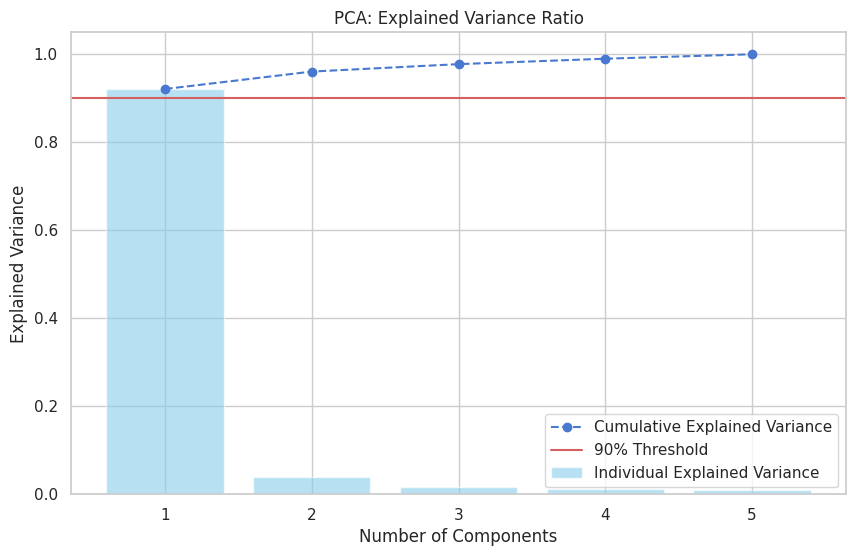


Final Data Shape after PCA (X_pca): (700, 2)
Total variance explained by 2 components: 0.96


In [11]:
from sklearn.decomposition import PCA

# Initialize and fit PCA
pca = PCA(n_components=None)
pca.fit(X_processed)

# Plotting explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance,
         marker='o', linestyle='--', label='Cumulative Explained Variance')
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio,
        alpha=0.6, color='skyblue', label='Individual Explained Variance')

plt.title('PCA: Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='-', label='90% Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Applying PCA with the chosen number of components (based on the plot)
n_components_final = 2

pca_final = PCA(n_components=n_components_final)
X_pca = pca_final.fit_transform(X_processed)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

print(f"\nFinal Data Shape after PCA (X_pca): {X_pca.shape}")
print(f"Total variance explained by {n_components_final} components: {cumulative_variance[n_components_final - 1]:.2f}")

## K-means Clustering - Model Building and training

First I'm going to use K-Means Clustering, a centroid-based partitioning algorithm. The goal of K-Means is to partition the dataset into k distinct, non-overlapping clusters, where each data point belongs to the cluster with the nearest mean. K-means clustering should show us personas naturally emerging from the data.

### The Elbow Method
To apply the K-Means Clustering algorithm, I have to determine the optimal number of clusters. Unlike hierarchical methods, K-Means requires this parameter to be specified up front. I'm going to use the Elbow Method, a heuristic technique used to assess the quality of clustering across different values.

I'm going to look at Distortion metric, which represents the sum of squared distances between each data point and its assigned cluster centroid. Lower inertia values indicate that data points are closer to their centroids, implying more cohesive clusters.

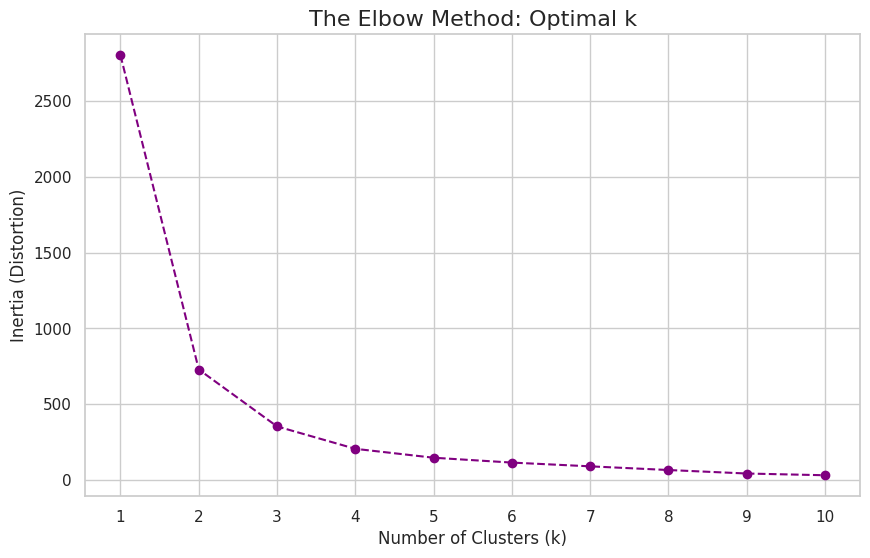

In [12]:
# Elbow plot
from sklearn.cluster import KMeans

# Runing K-Means for a range of clusters (k=1 to 10)
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca) # Use the PCA data
    inertia.append(kmeans.inertia_)

# Visualize Elbow
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--', color='purple')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Distortion)', fontsize=12)
plt.title('The Elbow Method: Optimal k', fontsize=16)
plt.xticks(k_range)
plt.grid(True)
plt.show()

The elbow plot above starts flattening after 3 clusters. This seems liek the right number for K-means.

### K-means - training

Based on the elbow method I established that I need to traing K-means with 3 clusters. I'll plot the results on a scatter plot to identify the personas (based on groupings of observations).

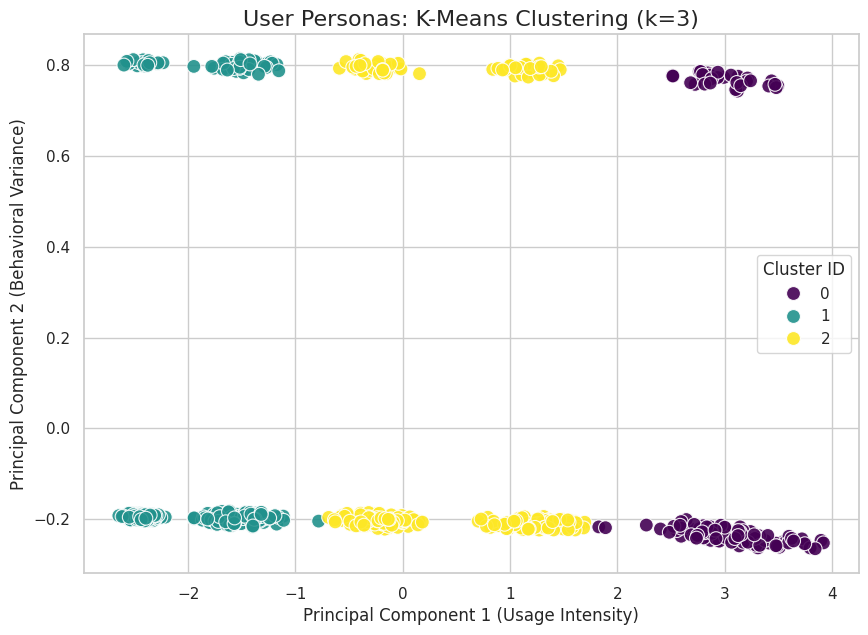

User personas


,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Data Usage (MB/day),Count
Cluster,,,,,
0,540.195652,10.082609,2695.376812,1967.521739,138
1,97.770318,2.297880,678.879859,332.724382,283
2,313.885305,5.911111,1804.752688,1022.010753,279



OS distribution per cluster


Operating System,Android,iOS
Cluster,,
0,107,31
1,229,54
2,218,61


In [13]:
# Fit the Final Model with k=3
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_pca)

# Add labels to dataframes for analysis
df_pca['Cluster'] = clusters
df['Cluster'] = clusters

# User persona map
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100, alpha=0.9)
plt.title('User Personas: K-Means Clustering (k=3)', fontsize=16)
plt.xlabel('Principal Component 1 (Usage Intensity)')
plt.ylabel('Principal Component 2 (Behavioral Variance)')
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()

# Interpretation
persona_summary = df.groupby('Cluster')[numerical_features].mean()
persona_summary['Count'] = df['Cluster'].value_counts()

print("User personas")
display(persona_summary)

# Optional: Check OS distribution per cluster
print("\nOS distribution per cluster")
display(pd.crosstab(df['Cluster'], df['Operating System']))

### Adding OS visualization

Before I summerize results, I noticed that results are clearly clustered into two separate lines. This is likely representation of OSes. I need to add additional column in my PCA dataframe to identify which line is which OS.

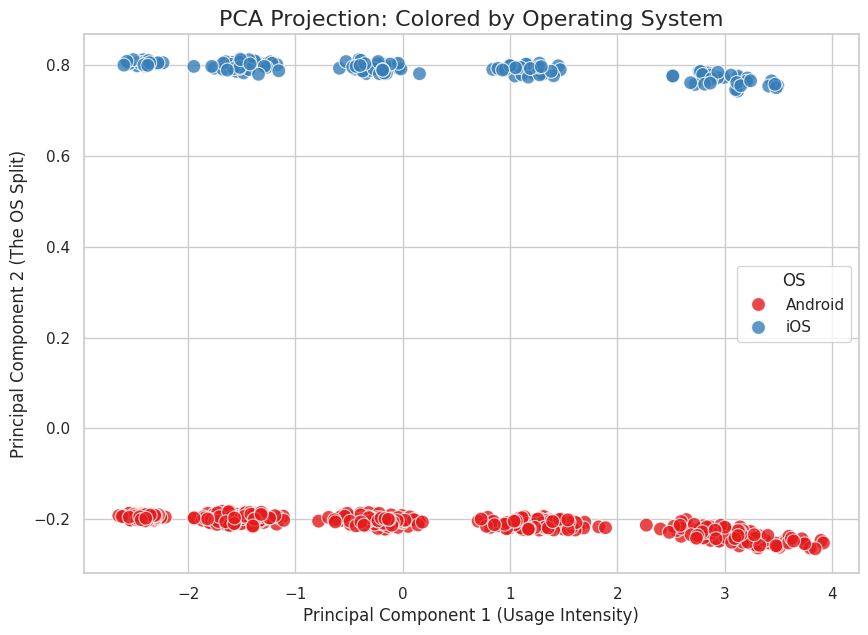

In [15]:
# Adding the OS column to your PCA dataframe so I can use it for coloring
df_pca['Operating System'] = df['Operating System']

# Plotting PC1 vs PC2 again, but adding color by OS this time
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Operating System', palette='Set1', s=100, alpha=0.8)

plt.title('PCA Projection: Colored by Operating System', fontsize=16)
plt.xlabel('Principal Component 1 (Usage Intensity)')
plt.ylabel('Principal Component 2 (The OS Split)')
plt.grid(True)
plt.legend(title='OS')
plt.show()

### K-means – results overview
K-Means clustering successfully identified three distinct user personas that cut across platform boundaries (OS vs. Android):

1. **Cluster 1 - The Minimalist**. This group represents 'utility' users. They average just 2.3 hours of screen time and consume minimal data (330 MB) and battery (680 mAh) per day. They likely use the device for specific, short-duration tasks rather than entertainment.

2. **Cluster 2 - The Standard User**. This is the baseline persona, averaging 6 hours of screen time and moderate resource consumption (1800 mAh). This group represents the 'typical' daily engagement pattern.

3. **Cluster 0 - The Power User**. This cluster revealed a segment of extreme engagement. With over 10 hours of daily screen time and nearly 2GB of data usage, these users drive the highest resource demand. Notably, their average battery drain (2700 mAh) suggests they are critical targets for battery optimization features. These users likely do a lot of compute heavy operations like playing games or watching 4k videos.

I also found that Operating System was not a defining factor for these personas. As seen in my PCA visualization, all three behavior types (Light, Medium, Heavy) exist in nearly equal proportions across both iOS and Android bands. 'Power Users' are platform-agnostic.

### K-means optimization – silhuatte

The Elbow Method is visual and somewhat subjective. To scientifically optimize k-means, I'm going to use the Silhouette Score. Silhouette score ranges from -1 to +1 (A higher number is better) and establishes whether users are well-matched to their own cluster and poorly matched to neighboring clusters.

#### Reference
Scikit-learn developers. (n.d.). Selecting the number of clusters with silhouette analysis on KMeans clustering. Scikit-learn. https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

k=2: Silhouette Score = 0.6279
k=3: Silhouette Score = 0.6033
k=4: Silhouette Score = 0.6226
k=5: Silhouette Score = 0.6267
k=6: Silhouette Score = 0.6858
k=7: Silhouette Score = 0.7143
k=8: Silhouette Score = 0.7125
k=9: Silhouette Score = 0.7397


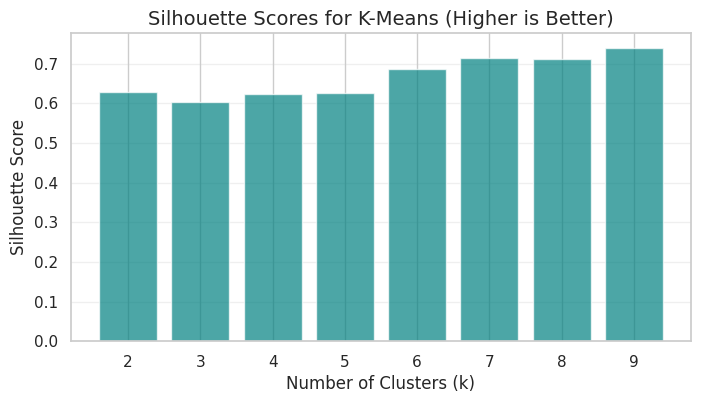

In [16]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    # Fitting model
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)

    # Calculate the score (Ranges from -1 to +1)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

# Visualize the Best K
plt.figure(figsize=(8, 4))
plt.bar(k_range, silhouette_scores, color='teal', alpha=0.7)
plt.title('Silhouette Scores for K-Means (Higher is Better)', fontsize=14)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(axis='y', alpha=0.3)
plt.show()

### K-means optimization – silhuette results
Silhouette Analysis showed surprising results disagreeing with the Elbow Method. While the Silhouette Score was high overall (>0.60), it generally increased with the number of clusters, peaking at 9.

This phenomenon apparently often occurs with linear data distributions (like our principal components), where increasing the number of partitions artificially minimizes within-cluster distance.

However, 9 clusters would be just impractical as a user segmentation. I decided to retain k=3 as the final model configuration. The differences between clusters is relatively small and 3 keeps solid semantic meaning.

## Hierarchical clustering

Since the end to my K-means training was somewhat controversial (Siluette disagreeing with the elbow method) I decided to implement Hierarchical Clustering and compare both models. Unlike K-Means, which requires a pre-specified number of clusters and partitions data based on centroids, Hierarchical Clustering builds a nested hierarchy of clusters without needing to know k in advance. This is perfect since it will let me avoid challenges with picking the number of clusters.


This algorithm uses a "bottom-up" approach: it treats each user as a single cluster and iteratively merges the two closest clusters until all users are unified into a single group. I'm going to utilize the Ward Linkage method, which merges clusters that result in the minimum increase in total within-cluster variance. I'm choosing this metric because it aligns mathematically with the objective function of K-Means, allowing for a fair "apples-to-apples" comparison between the two algorithms.

The resulting hierarchy will be visualized using a Dendrogram. By "cutting" the dendrogram at a specific height, we can obtain distinct clusters.

#### Reference
GeeksforGeeks. (n.d.). Hierarchical clustering. https://www.geeksforgeeks.org/machine-learning/hierarchical-clustering/

### Hierarchical clustering - training

The hierarchical clustering set-up is reltively straightforward. I just need to define the linkage ("ward" seems to be a popular method) and set up the dendrogram. I'm going to draw the line at 3 clusters so we can compare it to the K-means.

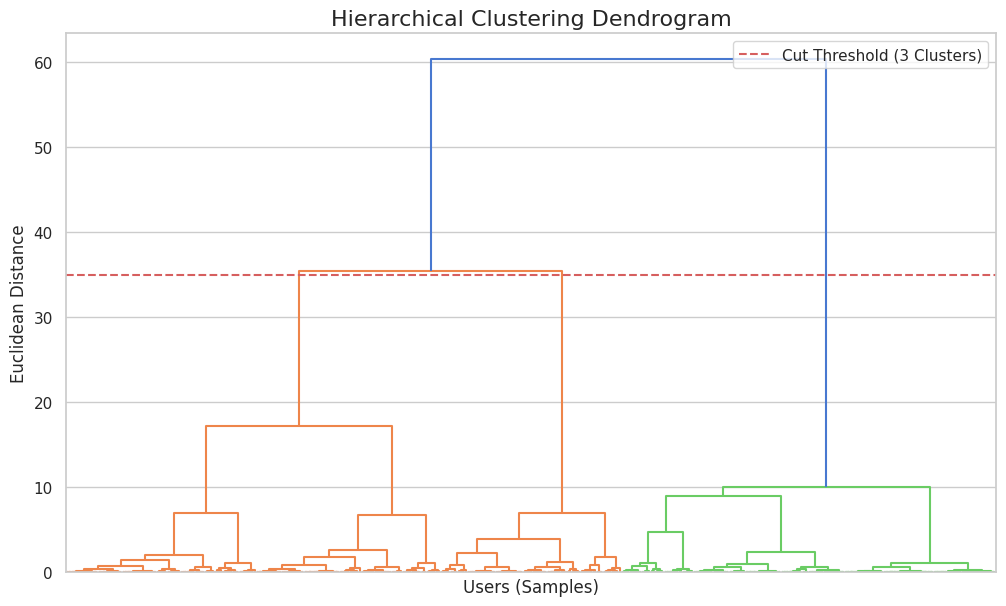


 Model Comparison: K-Means vs Hierarchical


Hierarchical Cluster,1,2,3
K-Means Cluster,,,
0,0,136,2
1,282,0,1
2,0,0,279


In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Linkage Matrix
linked = linkage(X_pca, method='ward')

# Plotting the Dendrogram
plt.figure(figsize=(12, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False,
           no_labels=True) # Hiding labels since we have 700 users

plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
plt.xlabel('Users (Samples)', fontsize=12)
plt.ylabel('Euclidean Distance', fontsize=12)

# Line where we would "cut" the tree to get 3 clusters
plt.axhline(y=35, color='r', linestyle='--', label='Cut Threshold (3 Clusters)')
plt.legend()
plt.show()

# Cut the Tree to Create Labels
hierarchical_labels = fcluster(linked, 3, criterion='maxclust')

# Comparison Table
print("\n Model Comparison: K-Means vs Hierarchical")
comparison_df = pd.crosstab(df['Cluster'], hierarchical_labels,
                            rownames=['K-Means Cluster'],
                            colnames=['Hierarchical Cluster'])
display(comparison_df)

### Hierarchical clustering - results

The results confirmed that 3 groups is the right choice.

The large vertical lines represent the distance between groups on the dendrogram. The taller the line, the more different the groups are. The red dashed line cuts the tree into 3 distinct branches. The Green branch on the right is one massive, distinct group. The Orange branch on the left splits into two smaller sub-groups.

Looking at the dendrogram I can clearly see the 3 groups that were also performing well in K-means.

Finally, I added a table comparing how K-Means labeled a user vs. how Hierarchical Clustering labeled the same user. The results are very much aligned:

* Row 1 (K-Means 1): You have 282 users. Hierarchical put 282 of them into its "Cluster 1" and only 1 into "Cluster 3". Result: 99.6% Agreement.

* Row 2 (K-Means 2): You have 279 users. Hierarchical put 279 of them into "Cluster 3". Result: 100% Agreement.

* Row 0 (K-Means 0): You have 138 users. Hierarchical put 136 into "Cluster 2" and only 2 elsewhere. Result: 98.5% Agreement.



### Hierarchical clustering - optimization

Diggiging a little deeper into Hierarchical Clustering I decided to test 3 different linkage methods and see if this is going to give me different, stronger results. I'm going to compare 'ward' (used in the first run), 'complete' and 'average'.

#### Reference
Scikit-learn developers. (n.d.). Comparing different hierarchical linkage methods on toy datasets. Scikit-learn. https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html

Linkage Method 'ward': Silhouette Score = 0.6039
Linkage Method 'complete': Silhouette Score = 0.6039
Linkage Method 'average': Silhouette Score = 0.6039


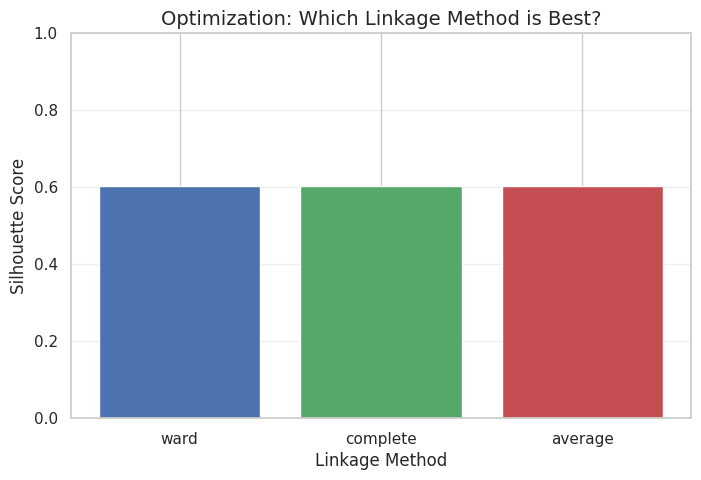


WINNER: The 'ward' method provides the best clustering quality.


In [18]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster

# 3 most common methods
methods = ['ward', 'complete', 'average']
best_score = -1
best_method = ''
scores = []

for method in methods:
    # Generate Linkage Matrix
    linked_test = linkage(X_pca, method=method)

    # Cutting the tree into 3 clusters (fixed k based on previous analysis)
    labels_test = fcluster(linked_test, 3, criterion='maxclust')

    # Calculating Silhouette Score
    score = silhouette_score(X_pca, labels_test)
    scores.append(score)

    print(f"Linkage Method '{method}': Silhouette Score = {score:.4f}")

    if score > best_score:
        best_score = score
        best_method = method

# Visualizing the comparison
plt.figure(figsize=(8, 5))
plt.bar(methods, scores, color=['#4c72b0', '#55a868', '#c44e52'])
plt.title('Optimization: Which Linkage Method is Best?', fontsize=14)
plt.xlabel('Linkage Method')
plt.ylabel('Silhouette Score')
plt.ylim(0, 1.0) # Scale it to see the difference clearly
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"\nWINNER: The '{best_method}' method provides the best clustering quality.")

### Hierarchical clustering - optimization - results

Ward, complete, and average produced identical Silhouette Scores (0.6039) indicating that my clusters are well-defined. The data points form such distinct, separated "islands" that it doesn't matter how they are measured, the distance (whether you look at the average distance or the maximum distance), the algorithm always finds the exact same groups.

## Conclusions

I'm happy to conclude that my unsupervised models  successfully identified clear and actionable segments in the mobile user behavior:
* **The Minimalist**. Low engagement (~2.3 hours/day), utilizing the device primarily for utilities.
* **The Standard User**. Moderate engagement (~6 hours/day), representing the baseline user behavior.
* **The Power User**. Extreme engagement (>10 hours/day), characterized by massive data consumption and battery drain.

Based on all the analysis and model training - this segmentation seems very reliable. The Hierarchical Clustering model validated the K-Means results with >99% agreement, and hyperparameter optimization showed that the cluster structure is stable regardless of the linkage metric used.

Intersetingly results are also platform independent. Operating System (iOS vs. Android) didn't make a difference for the whole analysis. My PCA analysis proved that "Power Users" and "Minimalists" exist in nearly equal proportions across both platforms. Designing exclusive features for one OS based on behavioral assumptions would be a strategic error.

## Future improvements in the model

It would be very interesting to get more data (more observations) and more features (e.g. the category of apps that users engage with) to create a more robust clustering model.

## UX Strategy Recommendations

Finally a word about the practical applicability of this model. In my opinion the three personas are very much actionable:

* The "Power User": Could use an aggressive battery optimization mode (especially when the device is inactive). With an average drain of ~2700 mAh, these users are the most likely to churn due to hardware limitations.
* The "Minimalist": Could benefit from a "Lite" UI. These users interact with their devices briefly. Bloated UI or complex navigation will lead to frustration.
* The "Standard User": This group represents the ideal target for standard A/B testing of new features, as they represent the median behavior without the extremes of the other two groups.



In [22]:
!pip freeze > requirements.txt